# Compulsory assignment 2

Author: Marie Klever

The following notebook presents my answer for the compulsory assigment 2 in DAT200.

Task: train different classifiers that predict the outcome of randomly selected shots made by Kobe Bryant, a former basketball player. Possible outcomes are 0 (missed shot) and 1 (shot made).

## Preparations

### Loading libraries
Loading the libraries to be used in this assignment.

In [1]:
%matplotlib inline 

import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from scipy.misc import imread

from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.feature_selection import VarianceThreshold, RFE, SelectFromModel

# Classification algorithms
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Perceptron, LogisticRegression

sns.set_style("whitegrid")

### Loading the dataset
Reading the dataset "KB_data.csv" to be used in the assignment.

In [2]:
data = pd.read_csv("KB_data.csv")
data.set_index('shot_id', inplace=True)

Looking at some of the data:

In [3]:
data.head(1)

,combined_shot_type,loc_x,loc_y,minutes_remaining,period,playoffs,season,seconds_remaining,shot_distance,shot_made_flag,shot_type,shot_zone_area,shot_zone_range,opponent
shot_id,,,,,,,,,,,,,,
2,Jump Shot,-157,0,10,1,0,2000-01,22,15,0.0,2PT Field Goal,Left Side(L),8-16 ft.,POR


In [4]:
data.dtypes

combined_shot_type     object
loc_x                   int64
loc_y                   int64
minutes_remaining       int64
period                  int64
playoffs                int64
season                 object
seconds_remaining       int64
shot_distance           int64
shot_made_flag        float64
shot_type              object
shot_zone_area         object
shot_zone_range        object
opponent               object
dtype: object

Changing some of the datatype from numeric to categorical to get a more descriptive statistic. Also changig all datatypes from object to categorical:

In [5]:
data["period"] = data["period"].astype("category")
data["playoffs"] = data["playoffs"].astype("category")
data["shot_made_flag"] = data["shot_made_flag"].astype("category")

data = pd.concat([data.select_dtypes([], ["object"]), 
                  data.select_dtypes(["object"]).apply(pd.Series.astype, dtype="category")], 
                 axis=1).reindex_axis(data.columns, axis=1)

In [6]:
data.dtypes

combined_shot_type    category
loc_x                    int64
loc_y                    int64
minutes_remaining        int64
period                category
playoffs              category
season                category
seconds_remaining        int64
shot_distance            int64
shot_made_flag        category
shot_type             category
shot_zone_area        category
shot_zone_range       category
opponent              category
dtype: object

## Summarizing and looking at statistics

### Data statistics
The dimensions of the dataset:

In [7]:
data.shape

(25697, 14)

Looking at the statistics for the numerical columns:

In [8]:
data.describe(include="number")

,loc_x,loc_y,minutes_remaining,seconds_remaining,shot_distance
count,25697.000000,25697.000000,25697.000000,25697.000000,25697.000000
mean,7.148422,91.257345,4.886796,28.311554,13.457096
std,110.073147,88.152106,3.452475,17.523392,9.388725
min,-250.000000,-44.000000,0.000000,0.000000,0.000000
25%,-67.000000,4.000000,2.000000,13.000000,5.000000
50%,0.000000,74.000000,5.000000,28.000000,15.000000
75%,94.000000,160.000000,8.000000,43.000000,21.000000
max,248.000000,791.000000,11.000000,59.000000,79.000000


Looking at the statistics for the object columns:

In [9]:
data.describe(include="category")

,combined_shot_type,period,playoffs,season,shot_made_flag,shot_type,shot_zone_area,shot_zone_range,opponent
count,25697,25697,25697,25697,20697.0,25697,25697,25697,25697
unique,6,7,2,20,2.0,2,6,5,33
top,Jump Shot,3,0,2005-06,0.0,2PT Field Goal,Center(C),Less Than 8 ft.,SAS
freq,19710,7002,21939,1924,11463.0,20285,11289,7857,1638


### Data statistics visualization
Looking at the distribution of the target column "shot_made_flag":

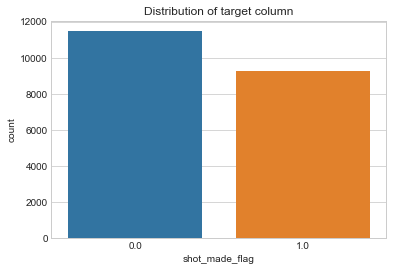

In [10]:
sns.countplot(x="shot_made_flag", data=data)
plt.title("Distribution of target column")
plt.show()

Looking at the distribution of the numerical columns using box plots. The green triangle shows the mean value:

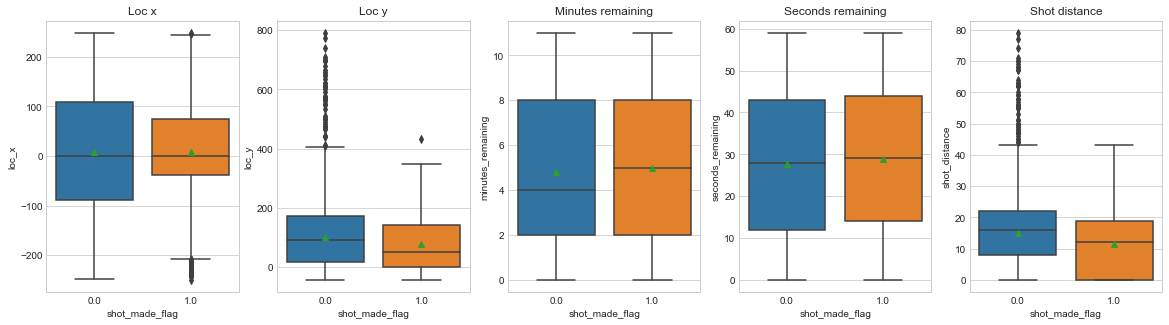

In [11]:
f, axes = plt.subplots(1, 5, figsize=(20, 5))

sns.boxplot(x="shot_made_flag", y="loc_x", data=data, showmeans=True, ax=axes[0]).set_title("Loc x")
sns.boxplot(x="shot_made_flag", y="loc_y", data=data, showmeans=True, ax=axes[1]).set_title("Loc y")
sns.boxplot(x="shot_made_flag", y="minutes_remaining", data=data, showmeans=True, ax=axes[2]).set_title("Minutes remaining")
sns.boxplot(x="shot_made_flag", y="seconds_remaining", data=data, showmeans=True, ax=axes[3]).set_title("Seconds remaining")
sns.boxplot(x="shot_made_flag", y="shot_distance", data=data, showmeans=True, ax=axes[4]).set_title("Shot distance")

plt.show()

Looking at the distribution of the categorical columns:

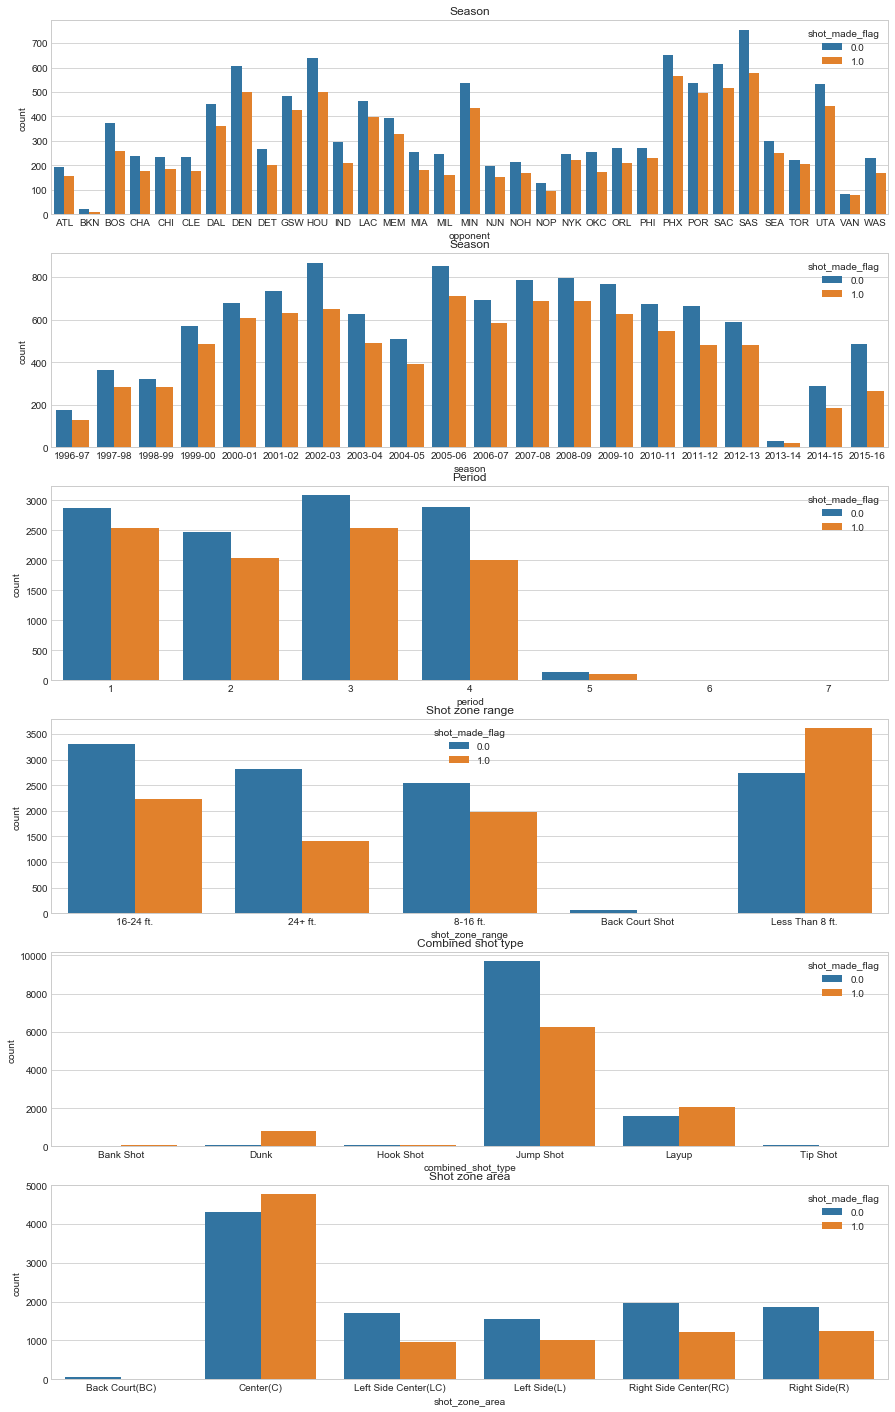

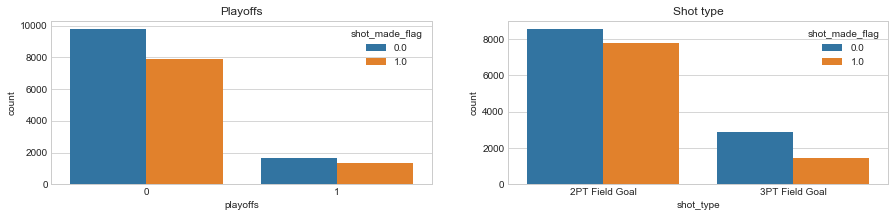

In [12]:
f1, axes = plt.subplots(6, figsize=(15, 25))
f2, axees = plt.subplots(1, 2, figsize=(15, 3))

sns.countplot(x="opponent", hue="shot_made_flag", data=data, ax=axes[0]).set_title("Season")
sns.countplot(x="season", hue="shot_made_flag", data=data, ax=axes[1]).set_title("Season")
sns.countplot(x="period", hue="shot_made_flag", data=data, ax=axes[2]).set_title("Period")
sns.countplot(x="shot_zone_range", hue="shot_made_flag", data=data, ax=axes[3]).set_title("Shot zone range")
sns.countplot(x="combined_shot_type", hue="shot_made_flag", data=data, ax=axes[4]).set_title("Combined shot type")
sns.countplot(x="shot_zone_area", hue="shot_made_flag", data=data, ax=axes[5]).set_title("Shot zone area")
sns.countplot(x="playoffs", hue="shot_made_flag", data=data, ax=axees[0]).set_title("Playoffs")
sns.countplot(x="shot_type", hue="shot_made_flag", data=data, ax=axees[1]).set_title("Shot type")

plt.show()

## Prepare data

Finding the indexes of the testing data, so the dataset can later be split:

In [13]:
test_data_index = data["shot_made_flag"].isnull()

Preprocessing the whole dataset. Will later remove the rows that belong to the test data.

In [14]:
data_prep = data.copy()
target = data_prep["shot_made_flag"].copy()
data_prep.drop("shot_made_flag", axis=1, inplace=True)

In [15]:
data_prep.columns

Index(['combined_shot_type', 'loc_x', 'loc_y', 'minutes_remaining', 'period',
       'playoffs', 'season', 'seconds_remaining', 'shot_distance', 'shot_type',
       'shot_zone_area', 'shot_zone_range', 'opponent'],
      dtype='object')

In [16]:
# Choosing features by myself logically

# choosing features
data_prep_myself = data_prep[["combined_shot_type", "shot_distance", "loc_x", "loc_y", "period", "shot_zone_area"]]
data_prep_myself.head()

,combined_shot_type,shot_distance,loc_x,loc_y,period,shot_zone_area
shot_id,,,,,,
2,Jump Shot,15,-157,0,1,Left Side(L)
3,Jump Shot,16,-101,135,1,Left Side Center(LC)
4,Jump Shot,22,138,175,1,Right Side Center(RC)
5,Dunk,0,0,0,2,Center(C)
6,Jump Shot,14,-145,-11,3,Left Side(L)


### Making new features

In [17]:
# total remaining time and last ten seconds
data_prep_myself["sec_from_period_end"] = data_prep["minutes_remaining"] * 60 + data_prep["seconds_remaining"]
data_prep["sec_from_period_end"] = data_prep["minutes_remaining"] * 60 + data_prep["seconds_remaining"]

data_prep.drop("minutes_remaining", axis=1, inplace=True)
data_prep.drop("seconds_remaining", axis=1, inplace=True)

# Dividing location x by location y

### Encoding categorical variables 

In [18]:
# Encoding my chosen features
data_prep_n = data_prep_myself.select_dtypes(include=["number"]).copy()
data_prep_ca = data_prep_myself.select_dtypes(include=["category"]).copy()
dummiess = pd.get_dummies(data_prep_ca, drop_first=True)
data_prep_myself = data_prep_n.join(dummiess)
print("Preprocessed data shape: {}".format(data_prep_myself.shape))

Preprocessed data shape: (25697, 20)


In [19]:
# Encoding all features
data_prep_num = data_prep.select_dtypes(include=["number"]).copy()
data_prep_cat = data_prep.select_dtypes(include=["category"]).copy()
dummies = pd.get_dummies(data_prep_cat, drop_first=True)
data_prep = data_prep_num.join(dummies)
print("Preprocessed data shape: {}".format(data_prep.shape))

Preprocessed data shape: (25697, 77)


Making a key for which columns are supposed to be standardised later on:

In [20]:
numerical_cols = list(data_prep_num)

### Final dataset
Preparing the datasets that will be used in the classifications:

In [21]:
# My chosen features

test_data_myself = data_prep_myself[test_data_index]
X_myself = data_prep_myself[~test_data_index]
y = target[~test_data_index]

print("Test dataset shape: {}".format(test_data_myself.shape))
print("Train dataset shape: {}".format(X_myself.shape))
print("Target dataset shape: {}".format(y.shape))

Test dataset shape: (5000, 20)
Train dataset shape: (20697, 20)
Target dataset shape: (20697,)


In [22]:
# All features

test_data = data_prep[test_data_index]
X = data_prep[~test_data_index]
#y = target[~test_data_index]

print("Test dataset shape: {}".format(test_data.shape))
print("Train dataset shape: {}".format(X.shape))
print("Target dataset shape: {}".format(y.shape))

Test dataset shape: (5000, 77)
Train dataset shape: (20697, 77)
Target dataset shape: (20697,)


Looking at different methods for selecting the most important features and then combining the methods.

In [23]:
# Variance treshold
threshold = 0.90
vt = VarianceThreshold().fit(X)

feat_var_threshold = data_prep.columns[vt.variances_ > threshold * (1-threshold)]

In [24]:
# According to random forest classifier
cls = RandomForestClassifier()
cls.fit(X, y)

feature_imp = pd.DataFrame(cls.feature_importances_, index=X.columns, columns=["importance"])
feat_imp_20 = feature_imp.sort_values("importance", ascending=False).head(20).index

In [25]:
# Recursive feature elimination
rfe = RFE(LogisticRegression(), 20)
rfe.fit(X, y)

feature_rfe_scoring = pd.DataFrame({'feature': X.columns,'score': rfe.ranking_})
feat_rfe_20 = feature_rfe_scoring[feature_rfe_scoring['score'] == 1]['feature'].values

In [26]:
# combining the different important feature methods
arr = np.hstack([feat_var_threshold, feat_imp_20, feat_rfe_20])
best = np.unique(arr)

In [27]:
# dataframe with the best features
X_best = X.ix[:, best]
test_data_best = test_data.ix[:, best]

In [28]:
print("X shape: {}".format(X.shape))
print("X_myself shape: {}".format(X_myself.shape))
print("X_best shape: {}".format(X_best.shape))

X shape: (20697, 77)
X_myself shape: (20697, 20)
X_best shape: (20697, 38)


## Evaluate different algorithms

Looking at the following algorithms to find the optimal algorithm with the optimal parameters:
- Perceptron
- Logistic regression
- SVC Linear
- SVC
- Decision tree
- Random forest
- KNN

Defining the algorithms to be used:

In [29]:
def perceptron(**kwargs):
    return Perceptron(**kwargs)

def logReg(**kwargs):
    return LogisticRegression(**kwargs)

def svcLin(**kwargs):
    kwargs["dual"] = False
    return LinearSVC(**kwargs)

def svc(**kwargs):
    kwargs["max_iter"] = 1000
    return SVC(**kwargs)

def decTree(**kwargs):
    return DecisionTreeClassifier(**kwargs)

def randForest(**kwargs):
    kwargs["n_jobs"] = -1    # -1 -> number of parallell jobs is equal to the number of CPU cores
    return RandomForestClassifier(**kwargs)

def knn(**kwargs):
    kwargs["n_jobs"] = -1
    return KNeighborsClassifier(**kwargs)

### Hyperparameter tuning
Finding the optimal hyperparameters among the predefined set of parameters above. Using the method defined here to find the optimal parameters for a specified algorithm. The numerical values are also standardized here using the StandardScaler().

In [30]:
splits = 100
test_size = 0.3

In [31]:
def param_tuning(X, y, classifier, params, test_sz, splits, scaled_set):
    param_grid = ParameterGrid(params)
    
    train_accuracy = []
    test_accuracy = []
    params = []
    for param_comb in param_grid:
                
        train_acc = []
        test_acc = []
        for rs in range(0, splits):
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_sz, random_state=rs,
                                                               stratify=y)
                                                       
            cl = classifier(**param_comb)
            
            # decision tree and random forest does not need to be scaled
            if not isinstance(cl, (RandomForestClassifier, DecisionTreeClassifier)):
                sc = StandardScaler()
                X_train[scaled_set] = sc.fit_transform(X_train[scaled_set])                        
                X_test[scaled_set] = sc.transform(X_test[scaled_set])
            
            cl.fit(X_train, y_train)
            
            train_ac = cl.score(X_train, y_train)
            test_ac = cl.score(X_test, y_test)
            
            train_acc.append(train_ac)
            test_acc.append(test_ac)
            #print("Param {}, split {}".format(param_comb, rs))

        train_accuracy.append(np.mean(train_acc))
        test_accuracy.append(np.mean(test_acc))
        params.append(param_comb)
    
    return {"train_accuracy": train_accuracy, "test_accuracy": test_accuracy, "params": params}

Defining the hyperparameters to be selected from for each algorithm:

In [34]:
hyperparameters = {"perceptron": {"n_iter" : [5, 7]}, 
                  "logReg": {"C" : [0.1, 0.4]},
                  "svcLin": {"C": [0.01, 0.02]},
                  "svc": {"C": [0.1, 0.2]},
                  "decTree": {"max_depth": [3]},
                  "randForest": {"n_estimators": [30, 50, 100]},
                  "knn": {"n_neighbors": [2, 9], "p": [2, 6]}}

### SVC Linear
Testing the SVM linear classifier for the optimal value of C, on the three different datasets.

In [35]:
cl = "svcLin"
results_3_X = param_tuning(X, y, locals()[cl], hyperparameters[cl], test_size, splits, numerical_cols)
results_3_X_myself = param_tuning(X_myself, y, locals()[cl], hyperparameters[cl], test_size, splits, numerical_cols)
results_3_X_best = param_tuning(X_best, y, locals()[cl], hyperparameters[cl], test_size, splits, numerical_cols)

In [37]:
print("Dataset X gave the following values \n")

for keys, values in results_3_X.items():
    print("{}: {}".format(keys, values))
    
print("\nDataset X_myself gave the following values \n")

for keys, values in results_3_X_myself.items():
    print("{}: {}".format(keys, values))
    
print("\nDataset X_best gave the following values \n")

for keys, values in results_3_X_best.items():
    print("{}: {}".format(keys, values))

Dataset X gave the following values 

train_accuracy: [0.6157265134258302, 0.615810036584524]
test_accuracy: [0.6127665056360708, 0.6125925925925926]
params: [{'C': 0.01}, {'C': 0.02}]

Dataset X_myself gave the following values 

train_accuracy: [0.6146628011320495, 0.6147338993580452]
test_accuracy: [0.6140225442834139, 0.6139967793880837]
params: [{'C': 0.01}, {'C': 0.02}]

Dataset X_best gave the following values 

train_accuracy: [0.6150093186995237, 0.6150880099399461]
test_accuracy: [0.6131884057971014, 0.6132560386473429]
params: [{'C': 0.01}, {'C': 0.02}]


## Finalizing the submission
Retraining the best model with the best parameters on the whole dataset and predicting the results of the testing dataset. \n

The best classifier when uploading it to kaggle was the SVC Linear classifier with the C parameter of 0.01 and the X dataset. \n

The best classifier I got in this notebook was the SVC Linear classifier with a C parameter of 0.01 and the X_myself dataset. This is the one I have chosen to use on Kaggle.

In [42]:
best_params = {"svcLin": {"C": 0.01}}

X_end = X_myself.copy()
X_test_end = test_data_myself.copy()

sc = StandardScaler()
X_end[numerical_cols] = sc.fit_transform(X_end[numerical_cols])                        
X_test_end[numerical_cols] = sc.transform(X_test_end[numerical_cols])

model = svcLin(**best_params["svcLin"])
model.fit(X_end, y) 

LinearSVC(C=0.01, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [43]:
# make predictions for the test_data and submit these predictions
preds = model.predict(X_test_end)

submission = pd.DataFrame()
submission["shot_id"] = test_data.index
submission["shot_made_flag"]= preds

In [44]:
submission.to_csv("submission_svcLin_X_myself_final.csv",index=False)